In [3]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

In [4]:
def GetDarkChannel(image,size):
    b,g,r = cv2.split(image)
    #split channels of coloured image
    
    minrg = cv2.min(r,g)
    minimum = cv2.min(minrg,b)
    #calculate the per-element minimum of two arrays of rgb
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(size,size))
    #pass the shape and size of the kernel to cv2.getStructuringElement, so it's rectangular kernel
    
    dark = cv2.erode(minimum,kernel)
    #all the pixels near boundary will be rejected depending on the size of kernel.
    
    return dark

In [5]:
def GetAtmosphericLight(image,dark):
    [h,w] = image.shape[:2]
    imagesize = h*w
    #image.shape returns (height, width, channels) we took the height, width
    
    numberofpixels = int(max(math.floor(imagesize/1000),1))
    
    
    vec_dark = dark.reshape(imagesize)
    vec_image = image.reshape(imagesize,3)
    #reshape the dark image and original image 
    
    ids = vec_dark.argsort()
    #sort the vectors and return indices of them
    ids = ids[imagesize-numberofpixels::]
    
    atmos = np.zeros([1,3])
    #create an array to store each window value 
    
    for each in range(1,numberofpixels):
        atmos = atmos + vec_image[ids[each]]

    A = atmos / numberofpixels
    
    return A


In [6]:
def GetTransmEstimate(image,A,size):
    newim = np.empty(image.shape,image.dtype)
    #get a new copy of a image with the same shape and datatype
    
    for each in range(0,3):
        newim[:,:,each] = image[:,:,each]/A[0,each]
    #transfer it to grayish image, bcs in grayish image Ar = Ag = Ab
    
    omega = 0.95
    # omega is fraction of haze to keep in image (default is 0.95)
    transmission = 1 - omega*GetDarkChannel(newim,size)
    # t = 1-darkchannel/atmosphericlight
    
    return transmission


In [7]:
def GetGuidedfilter(image,p,r,eps):
    imean = cv2.boxFilter(image,cv2.CV_64F,(r,r))
    pmean = cv2.boxFilter(p, cv2.CV_64F,(r,r))
    ipmean = cv2.boxFilter(image*p,cv2.CV_64F,(r,r))
    #avreag and bluring
    #why cv2.CV_64F? because it's always safer to take bigger sizes
    
    ipcov = ipmean - imean*pmean
    #coveriance
    
    iimean = cv2.boxFilter(image*image,cv2.CV_64F,(r,r))
    ivar   = iimean - imean*imean

    a = ipcov/(ivar + eps)
    b = pmean - a*imean
    
    amean = cv2.boxFilter(a,cv2.CV_64F,(r,r))
    bmean = cv2.boxFilter(b,cv2.CV_64F,(r,r))

    q = amean*image + bmean
    return q


In [8]:
def Refine(image,et):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #convert image's colorspace to gray
    gray = np.float64(gray)/255
    #grayscale the image
    r = 60
    eps = 0.0001
    t = GetGuidedfilter(gray,et,r,eps)
    return t

In [9]:
def Recover(image,t,A,tx = 0.1):
    newim = np.empty(image.shape,image.dtype)
    #copy the image
    t = cv2.max(t,tx)
    #check the transmission's lower bound  
    for each in range(0,3):
        newim[:,:,each] = (image[:,:,each]-A[0,each])/t + A[0,each]

    return newim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


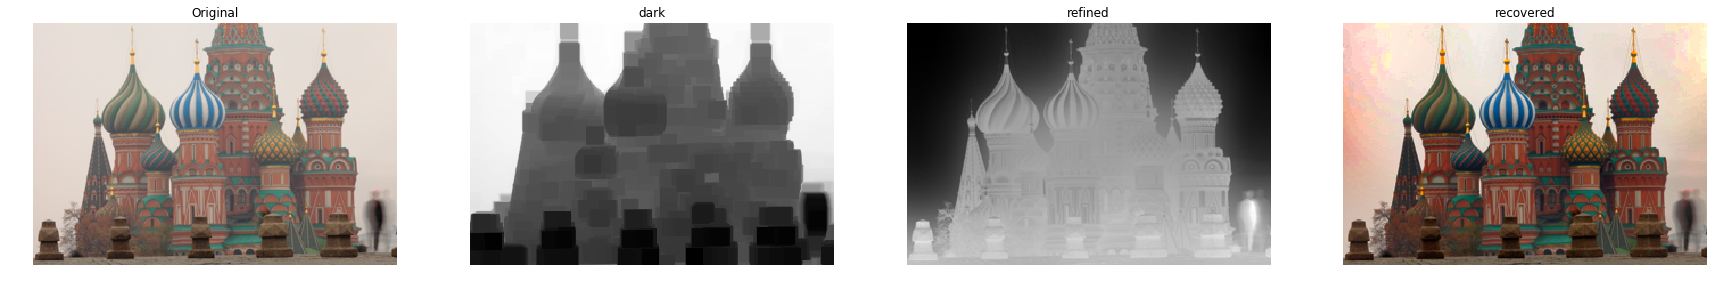

In [43]:
fn = 'Moscow Small.png'
src = cv2.imread(fn)
rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
I = rgb.astype('float64')/255
dark = GetDarkChannel(I,15)
A = GetAtmosphericLight(I,dark)
te = GetTransmEstimate(I,A,15)
t = Refine(src,te)
J = Recover(I,t,A,0.1)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,30))
gray = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
ax1.imshow(gray)
ax1.set_title("Original")
ax1.axis("off")
ax2.imshow(dark, cmap="gray")
ax2.set_title("dark")
ax2.axis("off")
ax3.imshow(t, cmap = "gray")
ax3.set_title("refined")
ax3.axis("off")
ax4.imshow(J)
ax4.set_title("recovered")
ax4.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


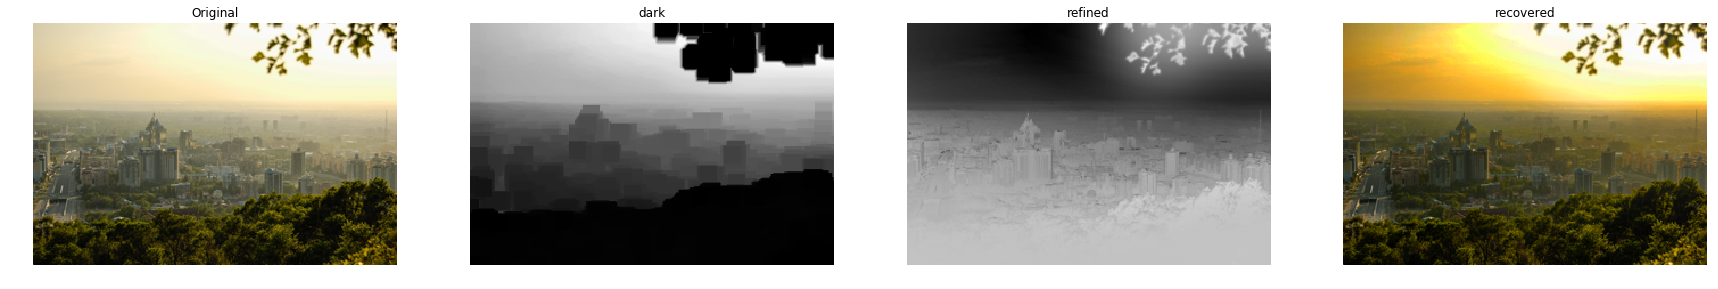

In [39]:
fn = 'Almaty Small.png'
src = cv2.imread(fn)
rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
I = rgb.astype('float64')/255
dark = GetDarkChannel(I,15)
A = GetAtmosphericLight(I,dark)
te = GetTransmEstimate(I,A,15)
t = Refine(src,te)
J = Recover(I,t,A,0.1)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,30))
gray = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
ax1.imshow(gray)
ax1.set_title("Original")
ax1.axis("off")
ax2.imshow(dark, cmap="gray")
ax2.set_title("dark")
ax2.axis("off")
ax3.imshow(t, cmap = "gray")
ax3.set_title("refined")
ax3.axis("off")
ax4.imshow(J,plt.cm.Spectral)
ax4.set_title("recovered")
ax4.axis("off")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


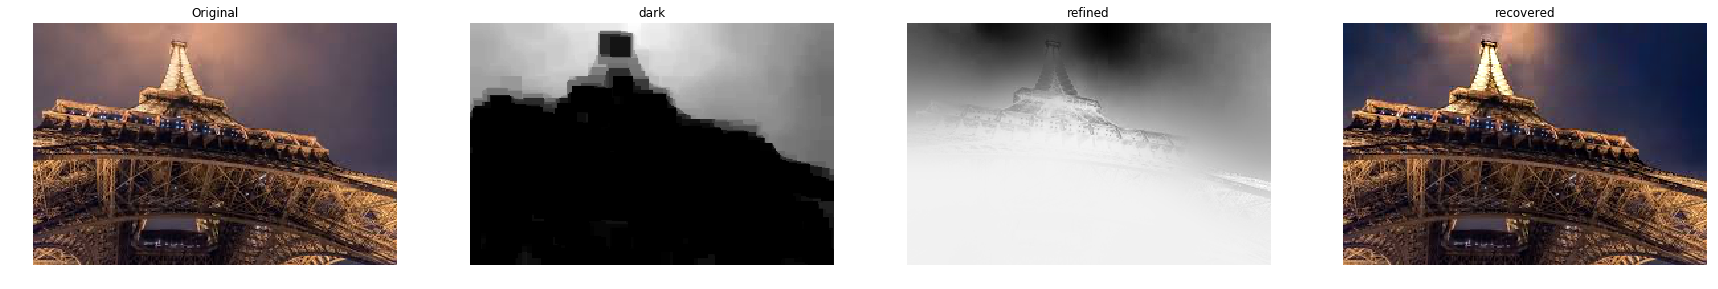

In [42]:
fn = 'paris Small.png'
src = cv2.imread(fn)
rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
I = rgb.astype('float64')/255
dark = GetDarkChannel(I,15)
A = GetAtmosphericLight(I,dark)
te = GetTransmEstimate(I,A,15)
t = Refine(src,te)
J = Recover(I,t,A,0.1)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,30))
gray = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
ax1.imshow(gray)
ax1.set_title("Original")
ax1.axis("off")
ax2.imshow(dark, cmap="gray")
ax2.set_title("dark")
ax2.axis("off")
ax3.imshow(t, cmap = "gray")
ax3.set_title("refined")
ax3.axis("off")
ax4.imshow(J,plt.cm.Spectral)
ax4.set_title("recovered")
ax4.axis("off")
plt.show()